In [87]:
from typing import TypeAlias
import math
import time
import json
import ctypes

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# gcc -shared -o functions.so -fPIC -O3 functions.c

In [88]:
lib = ctypes.CDLL('./functions.so')

In [89]:
np.random.seed(0)

In [90]:
Sample: TypeAlias = list[int | float]
Samples: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [91]:
# Activation functions

def ReLU():
    return 0

def Sigmoid():
    return 1

def Softmax():
    return 2

def Empty():
    return 3

In [92]:
# Loss functions

def MSELoss():
    return 0

def CrossEntropy():
    return 1

In [93]:
class Dataset:
    def __init__(self, samples: Samples, targets: Targets) -> None:
        self.samples: Samples = np.array(samples)
        self._len = len(samples)
        self.targets: Targets = np.array(targets)

    def __len__(self) -> int:
        return self._len

    def __getitem__(self, index) -> Sample:
        return self.samples[index], self.targets[index]

    def __iter__(self):
        return iter(zip(self.samples, self.targets))

In [94]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation = None) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        self.weights = []
        self.bias = []
        self.output = []

        if activation is None:
            self.activation = Empty()
        else:
            self.activation = activation

Layers: TypeAlias = list[Linear]

In [133]:
class Model:
    def __init__(self, layers: Layers, loss: int, regression: bool = True) -> None:
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss
        self.regression = regression

    def fit(self, dataset: Dataset, n_epoch: int = 1, learning_rate: float = 0.01, verbose: bool = True):
        dataset = [[sample, target] for sample, target in dataset]

        # Преобразуем данные для передачи в C
        flat_array_samples = []
        flat_array_targets = []
        for sample, target in dataset:
            arr = []
            for item in sample:
                arr.append(item)
            flat_array_samples.append(arr)
            flat_array_targets.append(target)
        # Конвертируем список в NumPy массив
        flat_array_samples = np.array(flat_array_samples, dtype=np.float64)
        flat_array_targets = np.array(flat_array_targets, dtype=np.float64)

        layer_sizes = []
        activations = []
        for layer in self.layers:
            layer_sizes.append([float(layer.n_inputs), float(layer.n_neurons)])
            activations.append(layer.activation)
        
        layer_sizes = np.array(layer_sizes)
        activations = np.array(activations, dtype=np.intc)

        # Описываем аргументы нашей функции
        lib.fit.argtypes = [
            ctypes.POINTER(ctypes.c_double),
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_int,
            ctypes.c_double,
            ctypes.c_int,
        ]

        lib.fit(
            flat_array_samples.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            flat_array_targets.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(flat_array_samples),
            len(flat_array_samples[0]),
            len(flat_array_targets),
            len(flat_array_targets[0]),
            layer_sizes.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(layer_sizes),
            len(layer_sizes[0]),
            activations.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(activations),
            self.loss,
            n_epoch,
            learning_rate,
            verbose,
        )

        with open("weights.json", 'r') as file:
            weights = json.load(file)

        with open("biases.json", 'r') as file:
            biases = json.load(file)

        for i in range(len(self.layers)):
            self.layers[i].weights = np.array(weights[i])
            self.layers[i].bias = np.array(biases[i], dtype=object)

    def predict(self, sample: Sample) -> float:
        sample = np.array(sample)
        biases = self.layers[0].bias
        weights = self.layers[0].weights

        layer_size = [float(self.layers[0].n_inputs), float(self.layers[0].n_neurons)]
        layer_size = np.array(layer_size)
        activation = self.layers[0].activation
        prediction = np.zeros(self.layers[0].n_neurons)

        lib.predict.argtypes = [
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_int,
            ctypes.c_int,
            ctypes.POINTER(ctypes.c_double),
        ]

        lib.predict(
            sample.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(sample),
            biases.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(biases),
            weights.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(weights),
            len(weights[0]),
            layer_size.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(layer_size),
            activation,
            prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        )

        self.layers[0].output = prediction

        for i in range(1, self._layers_len):
            sample = np.array(self.layers[i-1].output)
            biases = self.layers[i].bias
            weights = self.layers[i].weights

            layer_size = [float(self.layers[i].n_inputs), float(self.layers[i].n_neurons)]
            layer_size = np.array(layer_size)
            activation = self.layers[i].activation
            prediction = np.zeros(self.layers[i].n_neurons)

            lib.predict.argtypes = [
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_double),
            ]

            lib.predict(
                sample.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(sample),
                biases.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(biases),
                weights.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(weights),
                len(weights[0]),
                layer_size.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                len(layer_size),
                activation,
                prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            )
            self.layers[i].output = prediction

        if self.regression:
            return np.mean(self.layers[-1].output)
        else:
            return np.argmax(self.layers[-1].output)

    def set_weights(self, weights: Weights) -> None:
        for w, layer in zip(weights, self.layers):
            layer.weights = w

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

## Dataset

In [96]:
X = sorted(np.random.uniform(0, 10, 500))
y = [math.cos(x) for x in X]

X = np.array(X)
X = X.reshape(-1, 1)

y = np.array(y)
y = y.reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

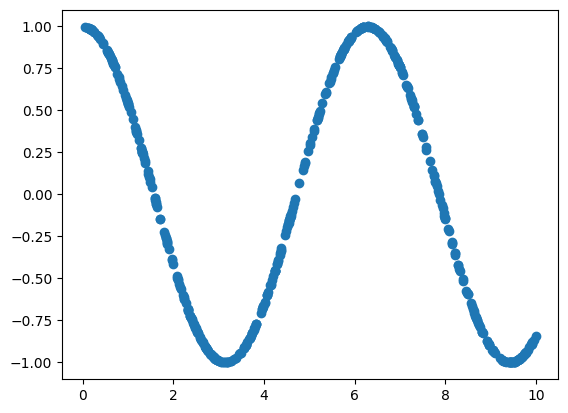

In [11]:
plt.plot(X, y, 'o')
plt.show()

In [12]:
lib = ctypes.CDLL('./functions.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(1,10, activation=Sigmoid()),
    Linear(10,1),
]

model = Model(layers=layers, loss=MSELoss(), regression=True)

model.fit(dataset=train_dataset, n_epoch=10, learning_rate=0.1, verbose=True)

Epoch 1 / 10. Loss: -0.079638
Epoch 2 / 10. Loss: -0.079638
Epoch 3 / 10. Loss: -0.079638
Epoch 4 / 10. Loss: -0.079638
Epoch 5 / 10. Loss: -0.079638
Epoch 6 / 10. Loss: -0.079638
Epoch 7 / 10. Loss: -0.079638
Epoch 8 / 10. Loss: -0.079638
Epoch 9 / 10. Loss: -0.079638
Epoch 10 / 10. Loss: -0.079638


In [616]:
preds = []
for i in X_val:
    pred = model.predict(i)
    preds.append(pred)

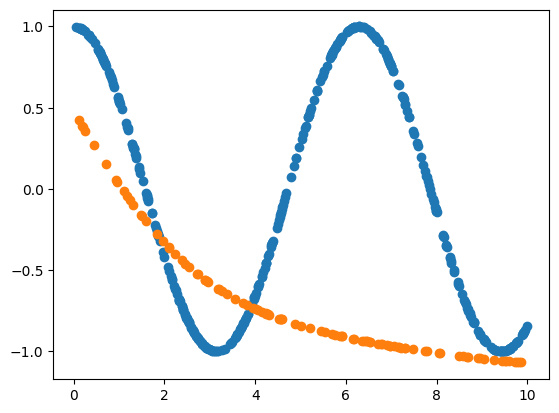

In [119]:
plt.plot(X_train, y_train, 'o')
plt.plot(X_val, preds, 'o')
plt.show()

# LinearRegression

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
sklearn_X_train = np.array(X_train)
sklearn_X_train = sklearn_X_train.reshape(-1, 1)

sklearn_y_val = np.array(y_val)
sklearn_y_val = sklearn_y_val.reshape(-1, 1)

In [32]:
sklearn_model = LinearRegression().fit(sklearn_X_train, y_train)

In [33]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

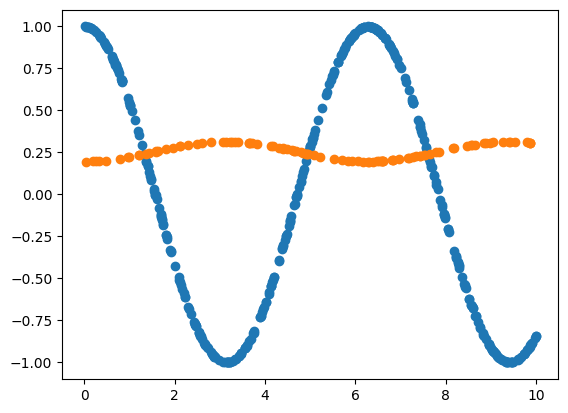

In [2834]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# MLPRegressor

In [967]:
from sklearn.neural_network import MLPRegressor

In [977]:
sklearn_model = MLPRegressor(random_state=0).fit(sklearn_X_train, y_train)

/Users/phil/Library/Python/3.12/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [978]:
sklearn_preds = sklearn_model.predict(sklearn_y_val)

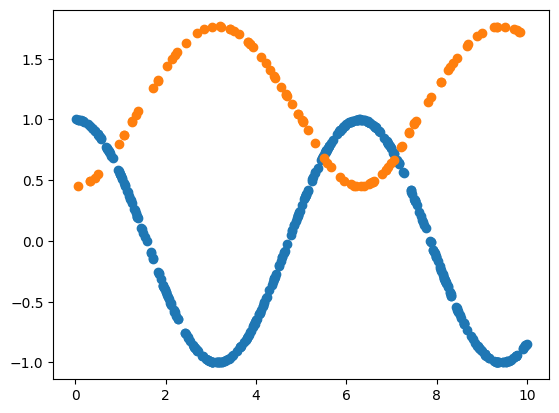

In [979]:
plt.plot(sklearn_X_train, y_train, 'o')
plt.plot(X_val, sklearn_preds, 'o')
plt.show()

# Make Moons dataset

In [134]:
from sklearn.datasets import make_moons

In [135]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)

y = list(y)
for i in range(len(y)):
    if y[i] == 0:
        y[i] = np.array([1, 0])
    elif y[i] == 1:
        y[i] = np.array([0, 1])

In [136]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

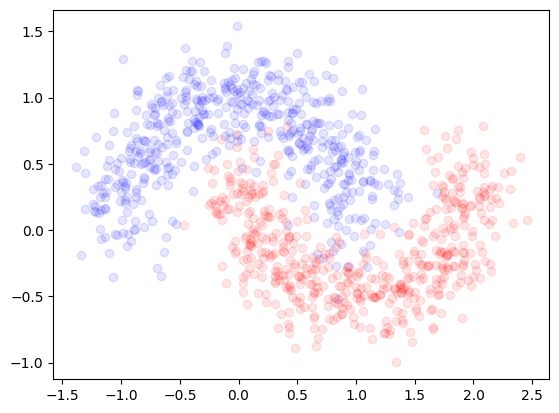

In [137]:
class_1_X = []
class_2_X = []

class_1_y = []
class_2_y = []

class_1_color = "blue"
class_2_color = "red"

for i in range(len(y)):
    if list(y[i]) == [1, 0]:
        class_1_X.append(X[i][0])
        class_1_y.append(X[i][1])
    elif list(y[i]) == [0, 1]:
        class_2_X.append(X[i][0])
        class_2_y.append(X[i][1])
    

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.1)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.1)
plt.show()

Epoch 1 / 10. Loss: 17.110210
Epoch 2 / 10. Loss: 19.299897
Epoch 3 / 10. Loss: 19.299897
Epoch 4 / 10. Loss: 19.299897
Epoch 5 / 10. Loss: 19.299897
Epoch 6 / 10. Loss: 19.299897
Epoch 7 / 10. Loss: 19.299897
Epoch 8 / 10. Loss: 19.299897
Epoch 9 / 10. Loss: 19.299897
Epoch 10 / 10. Loss: 19.299897


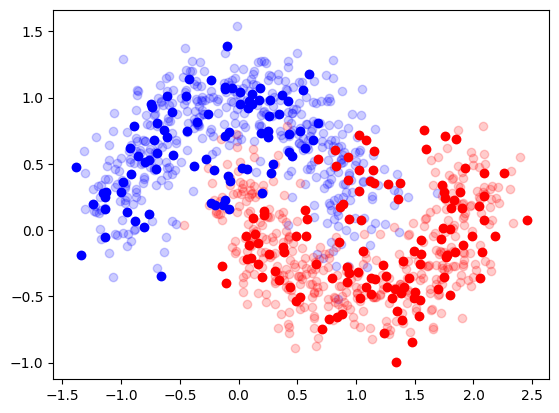

In [214]:
lib = ctypes.CDLL('./functions.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(2,2, activation=Sigmoid()),
    Linear(2,2, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False)

model.fit(dataset=train_dataset, n_epoch=10, learning_rate=0.1, verbose=True)


class_1_X_test = []
class_2_X_test = []

class_1_y_test = []
class_2_y_test = []

for i in X_val:
    pred = model.predict(i)
    if pred == 0:
        class_1_X_test.append(i[0])
        class_1_y_test.append(i[1])
    elif pred == 1:
        class_2_X_test.append(i[0])
        class_2_y_test.append(i[1])

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.2)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.2)
plt.plot(class_1_X_test, class_1_y_test, 'o', color=class_1_color, alpha=1)
plt.plot(class_2_X_test, class_2_y_test, 'o', color=class_2_color, alpha=1)
plt.show()

In [ ]:
lib = ctypes.CDLL('./functions.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(2,2, activation=Sigmoid()),
    Linear(2,2, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False)

model.fit(dataset=train_dataset, n_epoch=10, learning_rate=0.1, verbose=True)


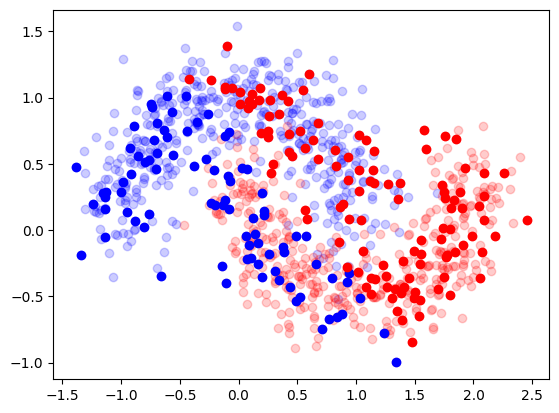

In [139]:
class_1_X_test = []
class_2_X_test = []

class_1_y_test = []
class_2_y_test = []

for i in X_val:
    pred = model.predict(i)
    if pred == 0:
        class_1_X_test.append(i[0])
        class_1_y_test.append(i[1])
    elif pred == 1:
        class_2_X_test.append(i[0])
        class_2_y_test.append(i[1])

plt.plot(class_1_X, class_1_y, 'o', color=class_1_color, alpha=0.2)
plt.plot(class_2_X, class_2_y, 'o', color=class_2_color, alpha=0.2)
plt.plot(class_1_X_test, class_1_y_test, 'o', color=class_1_color, alpha=1)
plt.plot(class_2_X_test, class_2_y_test, 'o', color=class_2_color, alpha=1)
plt.show()

# MNIST dataset

In [10]:
from sklearn.datasets import load_digits

In [25]:
dataset = load_digits(n_class=10)

In [30]:
X, y = dataset.data, dataset.target

for i in range(len(X)):
    X[i] = np.array(X[i])

for i in range(len(y)):
    y[i] = np.array(y[i])

y_one_hot = list(y)
for i in range(len(y)):
    if y[i] == 0:
        y_one_hot[i] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 1:
        y_one_hot[i] = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 2:
        y_one_hot[i] = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
    elif y[i] == 3:
        y_one_hot[i] = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    elif y[i] == 4:
        y_one_hot[i] = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    elif y[i] == 5:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    elif y[i] == 6:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
    elif y[i] == 7:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    elif y[i] == 8:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
    elif y[i] == 9:
        y_one_hot[i] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, train_size=0.8, random_state=0)

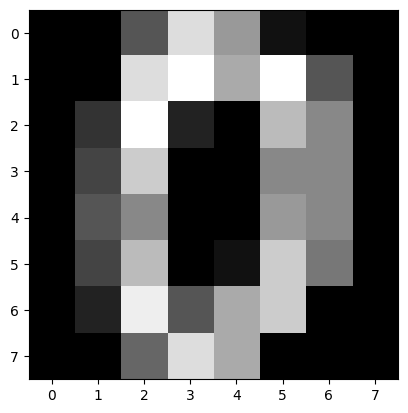

In [13]:
plt.imshow(X[0].reshape(8,8), cmap='gray')
plt.show()

In [ ]:
lib = ctypes.CDLL('./functions.so')

train_dataset = Dataset(samples=X_train, targets=y_train)

layers = [
    Linear(8*8,1000, activation=Sigmoid()),
    Linear(1000,10, activation=Softmax()),
]

model = Model(layers=layers, loss=CrossEntropy(), regression=False)

t_1 = time.time()
model.fit(dataset=train_dataset, n_epoch=1, learning_rate=0.1, verbose=True)
t_2 = time.time()

print(t_2 - t_1)

In [ ]:
preds = []
for i in X_val:
    pred = model.predict(i)
    preds.append(pred)

In [ ]:
print(preds)

In [ ]:
accuracy_score(y_true=y_val, y_pred=preds)